In [1]:
import scvi
import scanpy as sc
from sklearn.preprocessing import MinMaxScaler
import anndata as ad
from anndata import AnnData
import matplotlib

# Hierarchical Integration: scVI

In [2]:
target2 = sc.read_h5ad("/vol/data/ouologuems/data/preprocessed/target2_spherized_woSource9.h5ad")
target2

/vol/data/ouologuems/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 50376 × 601
    obs: 'Metadata_JCP2022', 'Metadata_InChIKey', 'Metadata_InChI', 'Metadata_Source', 'Metadata_Plate', 'Metadata_Well', 'Metadata_PlateType', 'SMILES_original', 'SMILES_standardized', 'InChI_standardized', 'InChIKey_standardized', 'broad_sample', 'InChIKey', 'pert_iname', 'pubchem_cid', 'target', 'pert_type', 'control_type', 'moa'
    uns: 'Metadata_Source_colors', 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

/vol/data/ouologuems/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/vol/data/ouologuems/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


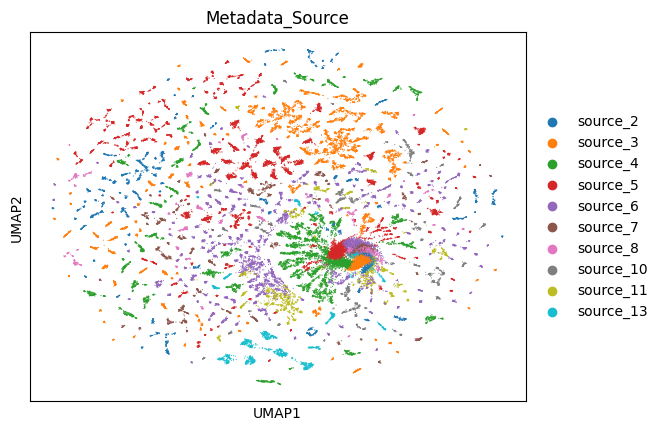

In [3]:
sc.pl.umap(target2, color = "Metadata_Source")

In [4]:
def scvi_integration(
    adata: AnnData,
    batch: str,
    max_epochs: int = 400,
    hierarchical: str = None,
) -> AnnData:
    """Function to perfrom integration with scVI

    Computes corrected feature matrix and embedding representation.
    When this method is called on a higher level (i.e. use output
    of previous run as input), one should call `reset_corrected_anndata`
    on the input before. Else, the original data from adata.X is used
    for the next level and not the corrected values.

    Args:
        adata:          AnnData object containing the data
        batch:          Name of the column in adata.obs which contains
                        the batch labels
        max_epochs:     Max number of epochs for training the model
        hierarchical:   Doesn't have an influence on the batch correction
                        when None. Else: correction of a "lower level"
                        of nested batch effects. The batch correction is
                        then performed separately for each group that is
                        defined by the column hierarchical in adata.obs

    Returns:
        AnnData:        Batch corrected AnnData object
    """
    scvi_adata = adata.copy()
    # min-max scaling because else you get exploding gradients
    scaler = MinMaxScaler()
    scvi_adata.X = scaler.fit_transform(scvi_adata.X)
    scvi_adata.layers["counts"] = scvi_adata.X

    if isinstance(hierarchical, str):
        # do batch correction on lower level (iterate over high-level batches)
        scvi_results = []
        for group in scvi_adata.obs[hierarchical].unique():
            adata_part = scvi_adata[scvi_adata.obs[hierarchical] == group].copy()
            #adata_part = scib.ig.scvi(adata_part, batch=batch, max_epochs=max_epochs)
            scvi.model.SCVI.setup_anndata(adata_part, batch_key=batch)
            model = scvi.model.SCVI(adata_part, gene_likelihood="normal")
            model.train()
            SCVI_LATENT_KEY = "X_scvi"
            adata_part.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()
            scvi_results.append(adata_part)
        scvi_adata = ad.concat(scvi_results, merge="same")
        return scvi_adata
    else:
        # do batch correction over all observations at once
        scvi.model.SCVI.setup_anndata(scvi_adata, batch_key=batch)
        model = scvi.model.SCVI(scvi_adata, gene_likelihood="normal")
        model.train()
        SCVI_LATENT_KEY = "X_scvi"
        scvi_adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()
        return scvi_adata

In [5]:
def reset_corrected_anndata(adata: AnnData, obsm_key: str = "X_emb") -> AnnData:
    """Prepare corrected AnnData object for next level of batch correction

    After batch correction, this method creates a new AnnData object from
    a corrected one where the corrected features (usually in X_emb) are
    saved in X. This is helpful if you want to iterate batch correction
    methods on different levels to remove nested batch effects.

    Args:
        adata:          AnnData object containing the corrected data
        obsm_key:       Key under which the corrected data is stored
                        in obsm of `adata`

    Returns:
        AnnData:        AnnData object with X_emb saved in X
    """
    new_adata = ad.AnnData(adata.obsm[obsm_key].copy())
    new_adata.obs = adata.obs.copy()
    return new_adata


Low level correction:

In [9]:
adata_scvi_per_source = scvi_integration(target2, batch= "Metadata_Plate", hierarchical="Metadata_Source")

/vol/data/ouologuems/miniconda3/envs/gaushvi/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/vol/data/ouologuems/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/vol/data/ouologuems/miniconda3/envs/gaushvi/lib/python3.10/site-packages/lightning/pytorch/tra

Epoch 400/400: 100%|██████████| 400/400 [01:40<00:00,  3.90it/s, v_num=1, train_loss_step=-1.22e+3, train_loss_epoch=-1.76e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:40<00:00,  4.00it/s, v_num=1, train_loss_step=-1.22e+3, train_loss_epoch=-1.76e+3]

/vol/data/ouologuems/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/vol/data/ouologuems/miniconda3/envs/gaushvi/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.



Epoch 400/400: 100%|██████████| 400/400 [13:36<00:00,  4.75it/s, v_num=1, train_loss_step=-1.53e+3, train_loss_epoch=-1.56e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [13:36<00:00,  2.04s/it, v_num=1, train_loss_step=-1.53e+3, train_loss_epoch=-1.56e+3]

/vol/data/ouologuems/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/vol/data/ouologuems/miniconda3/envs/gaushvi/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.



Epoch 400/400: 100%|██████████| 400/400 [01:30<00:00,  4.58it/s, v_num=1, train_loss_step=-2.24e+3, train_loss_epoch=-2.23e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:30<00:00,  4.40it/s, v_num=1, train_loss_step=-2.24e+3, train_loss_epoch=-2.23e+3]

/vol/data/ouologuems/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/vol/data/ouologuems/miniconda3/envs/gaushvi/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.



Epoch 400/400: 100%|██████████| 400/400 [01:59<00:00,  3.41it/s, v_num=1, train_loss_step=-2.13e+3, train_loss_epoch=-2.09e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:59<00:00,  3.35it/s, v_num=1, train_loss_step=-2.13e+3, train_loss_epoch=-2.09e+3]

/vol/data/ouologuems/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/vol/data/ouologuems/miniconda3/envs/gaushvi/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.



Epoch 400/400: 100%|██████████| 400/400 [04:51<00:00,  1.32it/s, v_num=1, train_loss_step=-1.8e+3, train_loss_epoch=-1.97e+3] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:51<00:00,  1.37it/s, v_num=1, train_loss_step=-1.8e+3, train_loss_epoch=-1.97e+3]


/vol/data/ouologuems/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/vol/data/ouologuems/miniconda3/envs/gaushvi/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [04:19<00:00,  1.53it/s, v_num=1, train_loss_step=-879, train_loss_epoch=-2.23e+3]    

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:19<00:00,  1.54it/s, v_num=1, train_loss_step=-879, train_loss_epoch=-2.23e+3]


/vol/data/ouologuems/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/vol/data/ouologuems/miniconda3/envs/gaushvi/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [04:40<00:00,  1.43it/s, v_num=1, train_loss_step=-1.93e+3, train_loss_epoch=-1.97e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:40<00:00,  1.43it/s, v_num=1, train_loss_step=-1.93e+3, train_loss_epoch=-1.97e+3]


/vol/data/ouologuems/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/vol/data/ouologuems/miniconda3/envs/gaushvi/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [04:04<00:00,  1.63it/s, v_num=1, train_loss_step=-1.68e+3, train_loss_epoch=-1.7e+3] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:04<00:00,  1.63it/s, v_num=1, train_loss_step=-1.68e+3, train_loss_epoch=-1.7e+3]


/vol/data/ouologuems/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/vol/data/ouologuems/miniconda3/envs/gaushvi/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [01:24<00:00,  4.68it/s, v_num=1, train_loss_step=-1.74e+3, train_loss_epoch=-1.75e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:24<00:00,  4.72it/s, v_num=1, train_loss_step=-1.74e+3, train_loss_epoch=-1.75e+3]

/vol/data/ouologuems/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/vol/data/ouologuems/miniconda3/envs/gaushvi/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.



Epoch 400/400: 100%|██████████| 400/400 [01:04<00:00,  6.17it/s, v_num=1, train_loss_step=-1.63e+3, train_loss_epoch=-1.65e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:04<00:00,  6.21it/s, v_num=1, train_loss_step=-1.63e+3, train_loss_epoch=-1.65e+3]


In [10]:
adata_scvi_per_source

AnnData object with n_obs × n_vars = 50376 × 601
    obs: 'Metadata_JCP2022', 'Metadata_InChIKey', 'Metadata_InChI', 'Metadata_Source', 'Metadata_Plate', 'Metadata_Well', 'Metadata_PlateType', 'SMILES_original', 'SMILES_standardized', 'InChI_standardized', 'InChIKey_standardized', 'broad_sample', 'InChIKey', 'pert_iname', 'pubchem_cid', 'target', 'pert_type', 'control_type', 'moa', '_scvi_batch', '_scvi_labels'
    obsm: 'X_umap', 'X_scvi'
    layers: 'counts'

/vol/data/ouologuems/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/vol/data/ouologuems/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


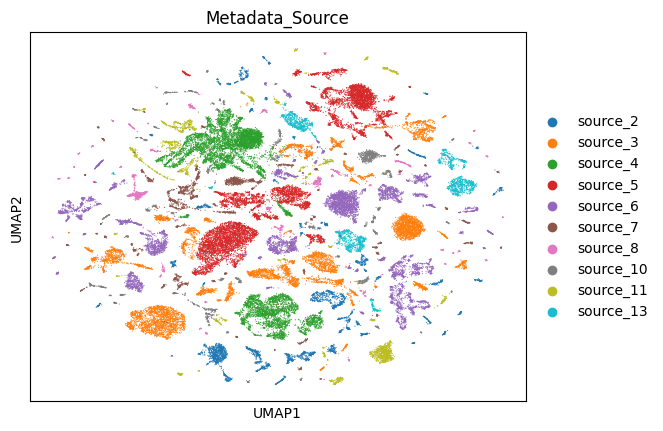

/vol/data/ouologuems/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/vol/data/ouologuems/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


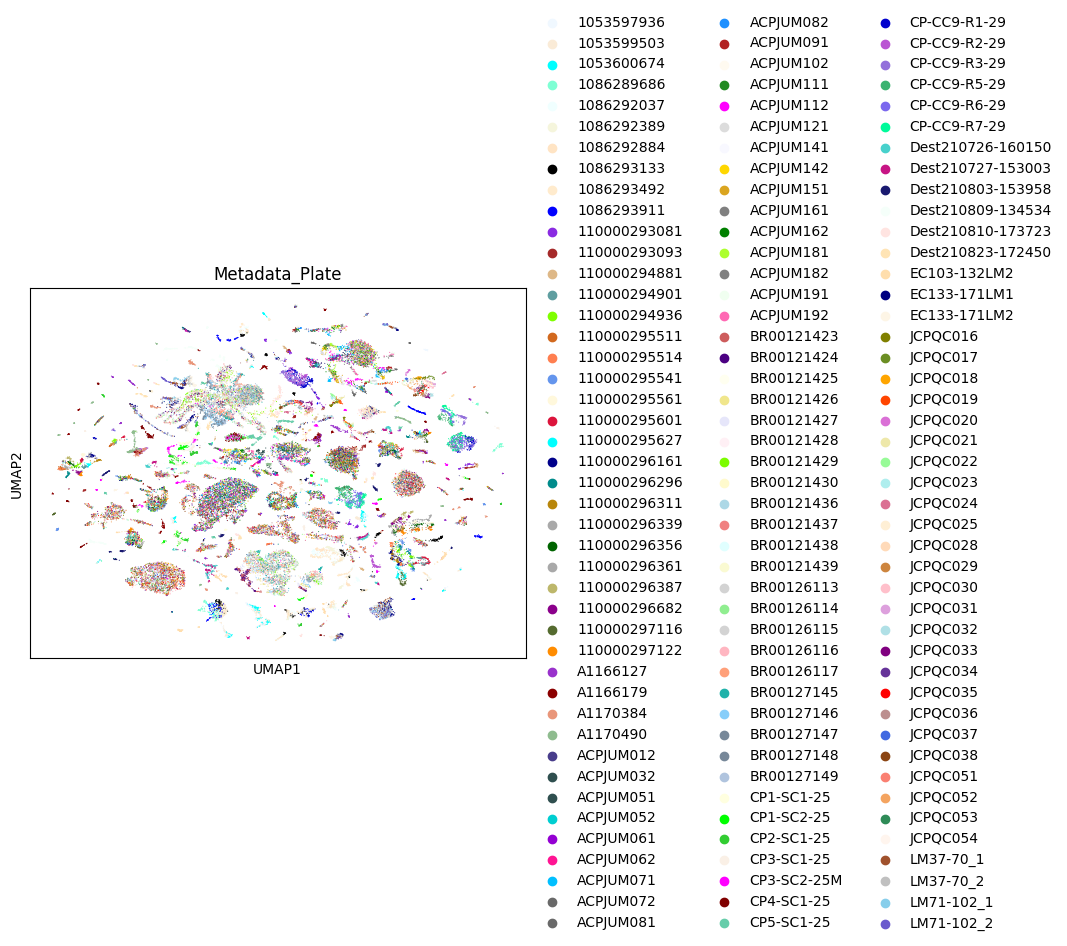

In [11]:
sc.pp.neighbors(adata_scvi_per_source, use_rep="X_scvi")
sc.tl.umap(adata_scvi_per_source)
sc.pl.umap(adata_scvi_per_source, color="Metadata_Source")
sc.pl.umap(adata_scvi_per_source, color="Metadata_Plate",palette=list(matplotlib.colors.CSS4_COLORS.values()))

/vol/data/ouologuems/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/vol/data/ouologuems/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


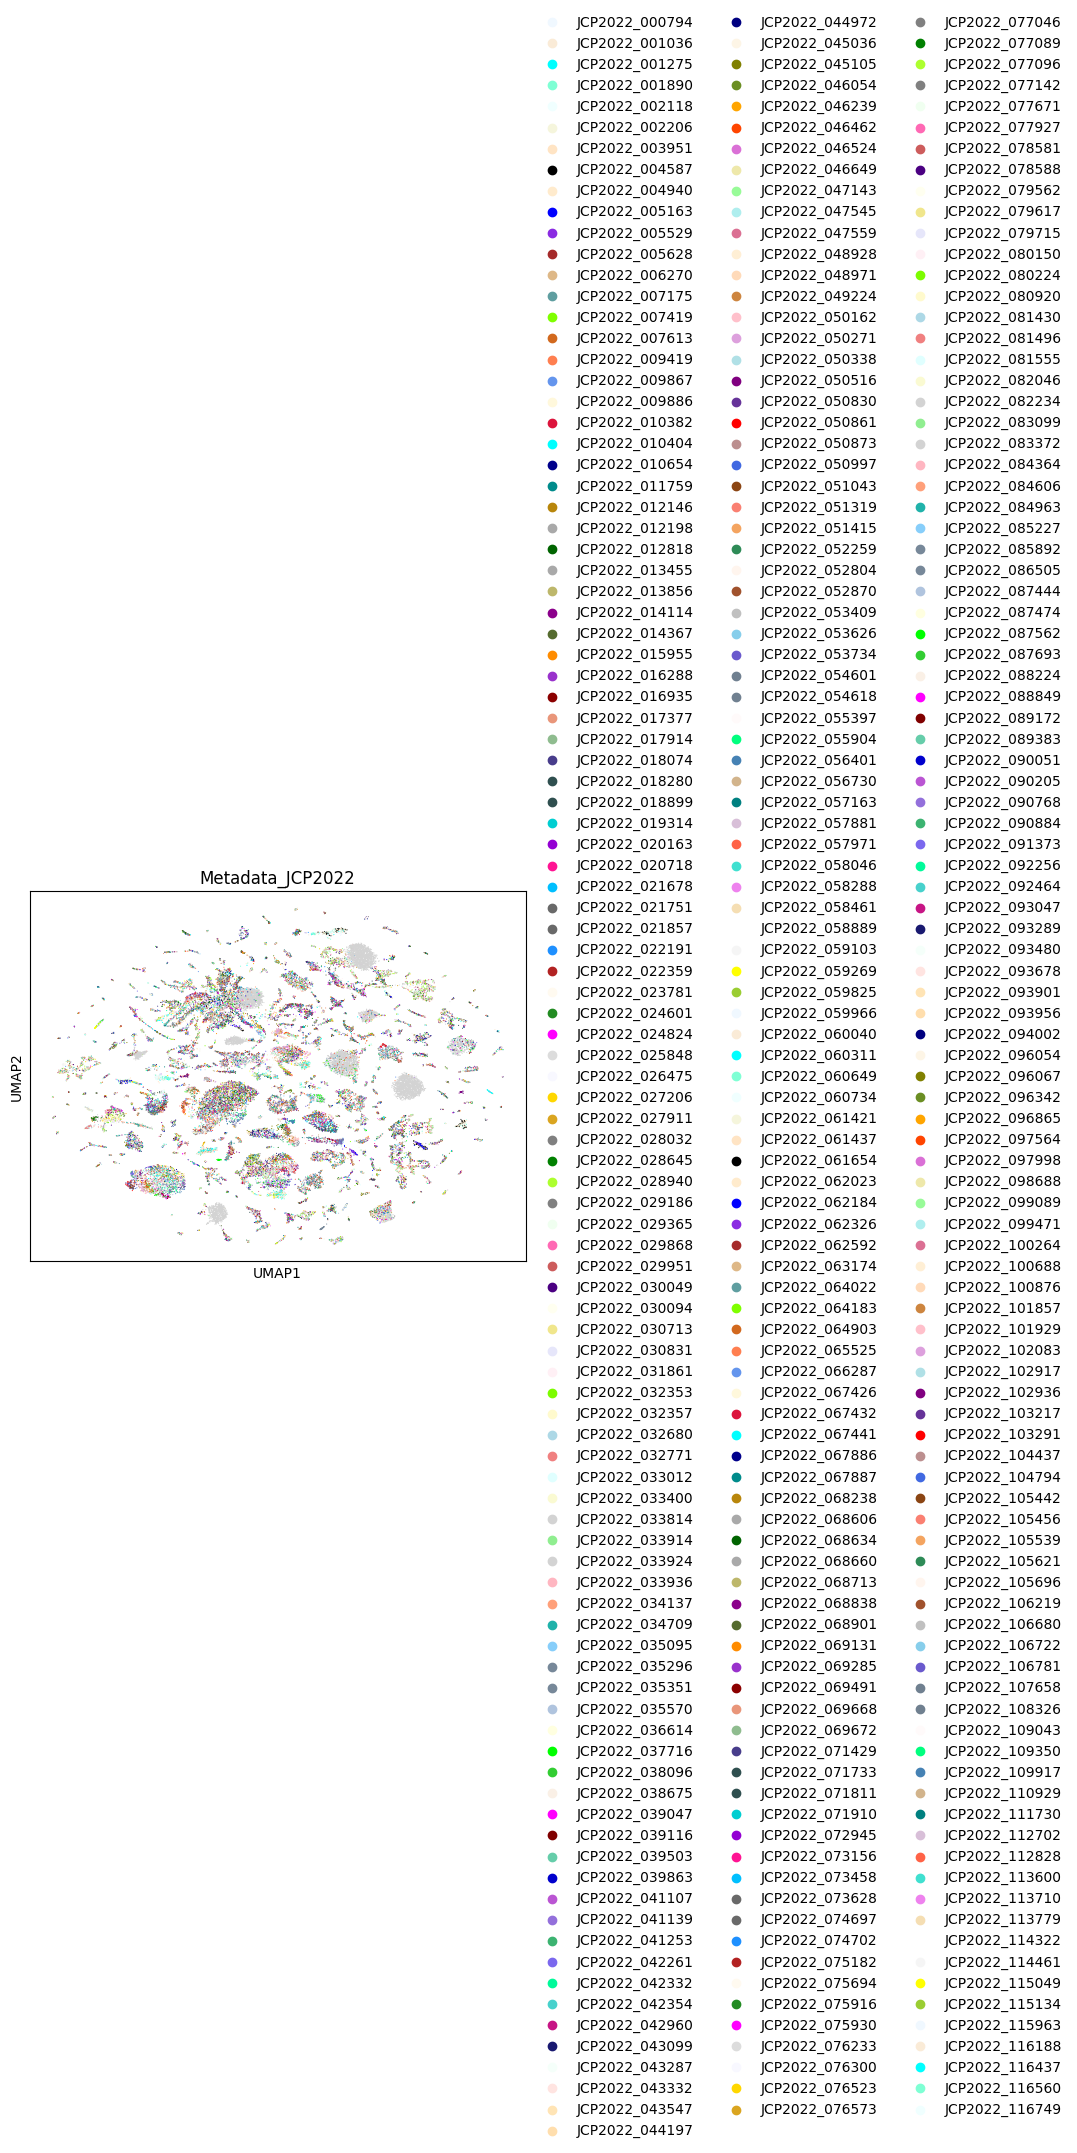

In [16]:
sc.pl.umap(adata_scvi_per_source, color="Metadata_JCP2022",palette=list(matplotlib.colors.CSS4_COLORS.values()))

In [12]:
adata_scvi_per_source.write_h5ad("/vol/data/ouologuems/data/integrated/gaushVI/low_level.h5ad")

High level correction: 

In [6]:
adata_scvi_per_source = sc.read_h5ad("/vol/data/ouologuems/data/integrated/gaushVI/low_level.h5ad")

In [7]:
scvi_adata = reset_corrected_anndata(adata_scvi_per_source, obsm_key = "X_scvi")
scaler = MinMaxScaler()
scvi_adata.X = scaler.fit_transform(scvi_adata.X)
scvi_adata.layers["counts"] = scvi_adata.X
scvi.model.SCVI.setup_anndata(scvi_adata, batch_key="Metadata_Source")
model = scvi.model.SCVI(scvi_adata, gene_likelihood="normal", n_latent=5)
model.train()
SCVI_LATENT_KEY = "X_scvi"
scvi_adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

/vol/data/ouologuems/miniconda3/envs/gaushvi/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/vol/data/ouologuems/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/vol/data/ouologuems/miniconda3/envs/gaushvi/lib/python3.10/site-packages/lightning/pytorch/tra

Epoch 1/159:   0%|          | 0/159 [00:00<?, ?it/s]

Epoch 159/159: 100%|██████████| 159/159 [05:32<00:00,  2.08s/it, v_num=1, train_loss_step=-23.1, train_loss_epoch=-24.7]

`Trainer.fit` stopped: `max_epochs=159` reached.


Epoch 159/159: 100%|██████████| 159/159 [05:32<00:00,  2.09s/it, v_num=1, train_loss_step=-23.1, train_loss_epoch=-24.7]


/vol/data/ouologuems/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/vol/data/ouologuems/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


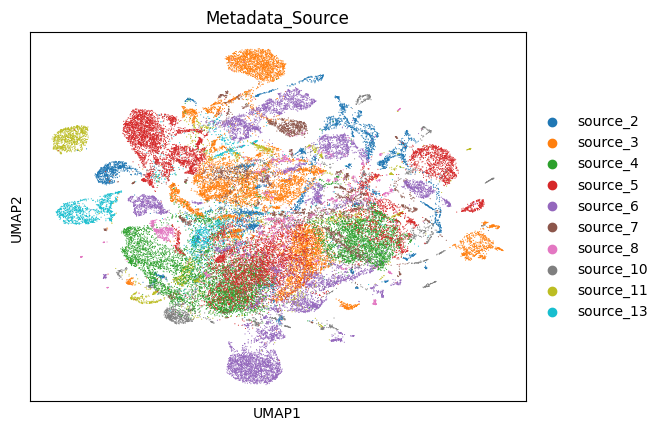

/vol/data/ouologuems/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/vol/data/ouologuems/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


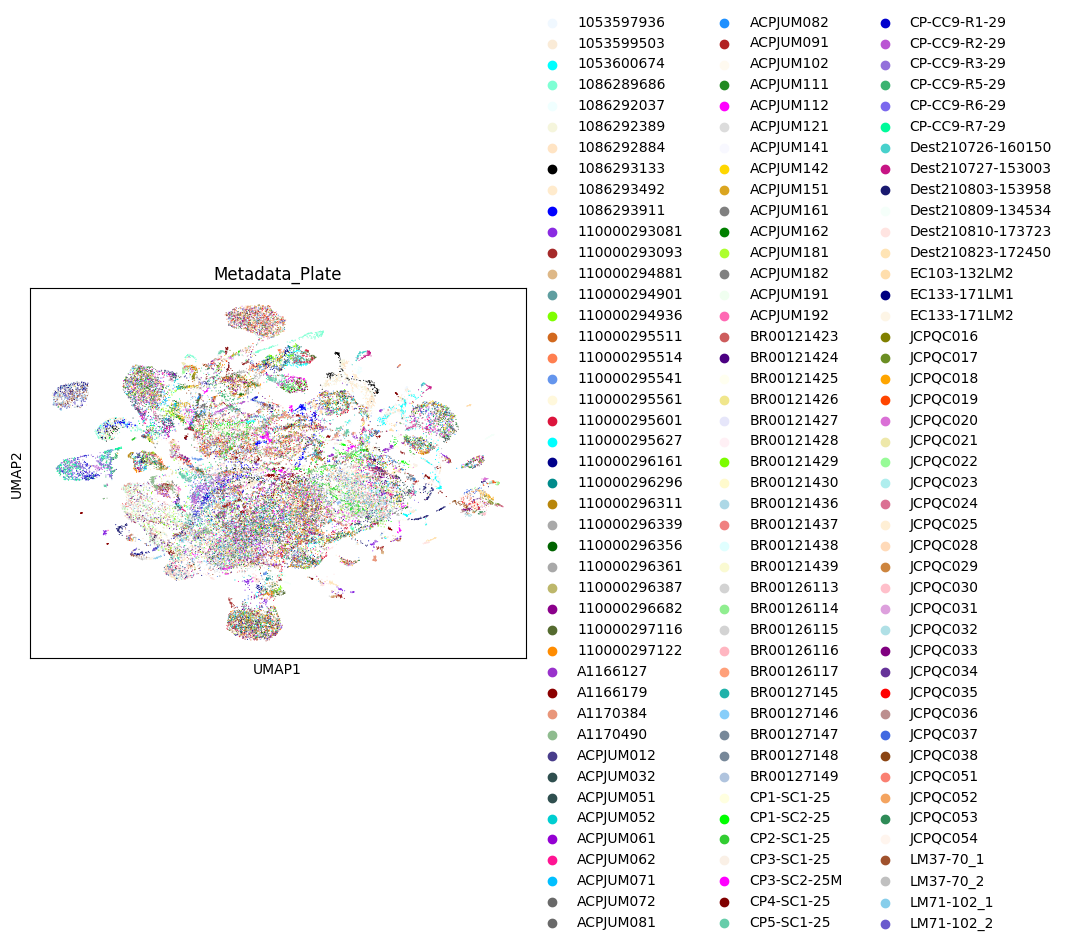

/vol/data/ouologuems/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/vol/data/ouologuems/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


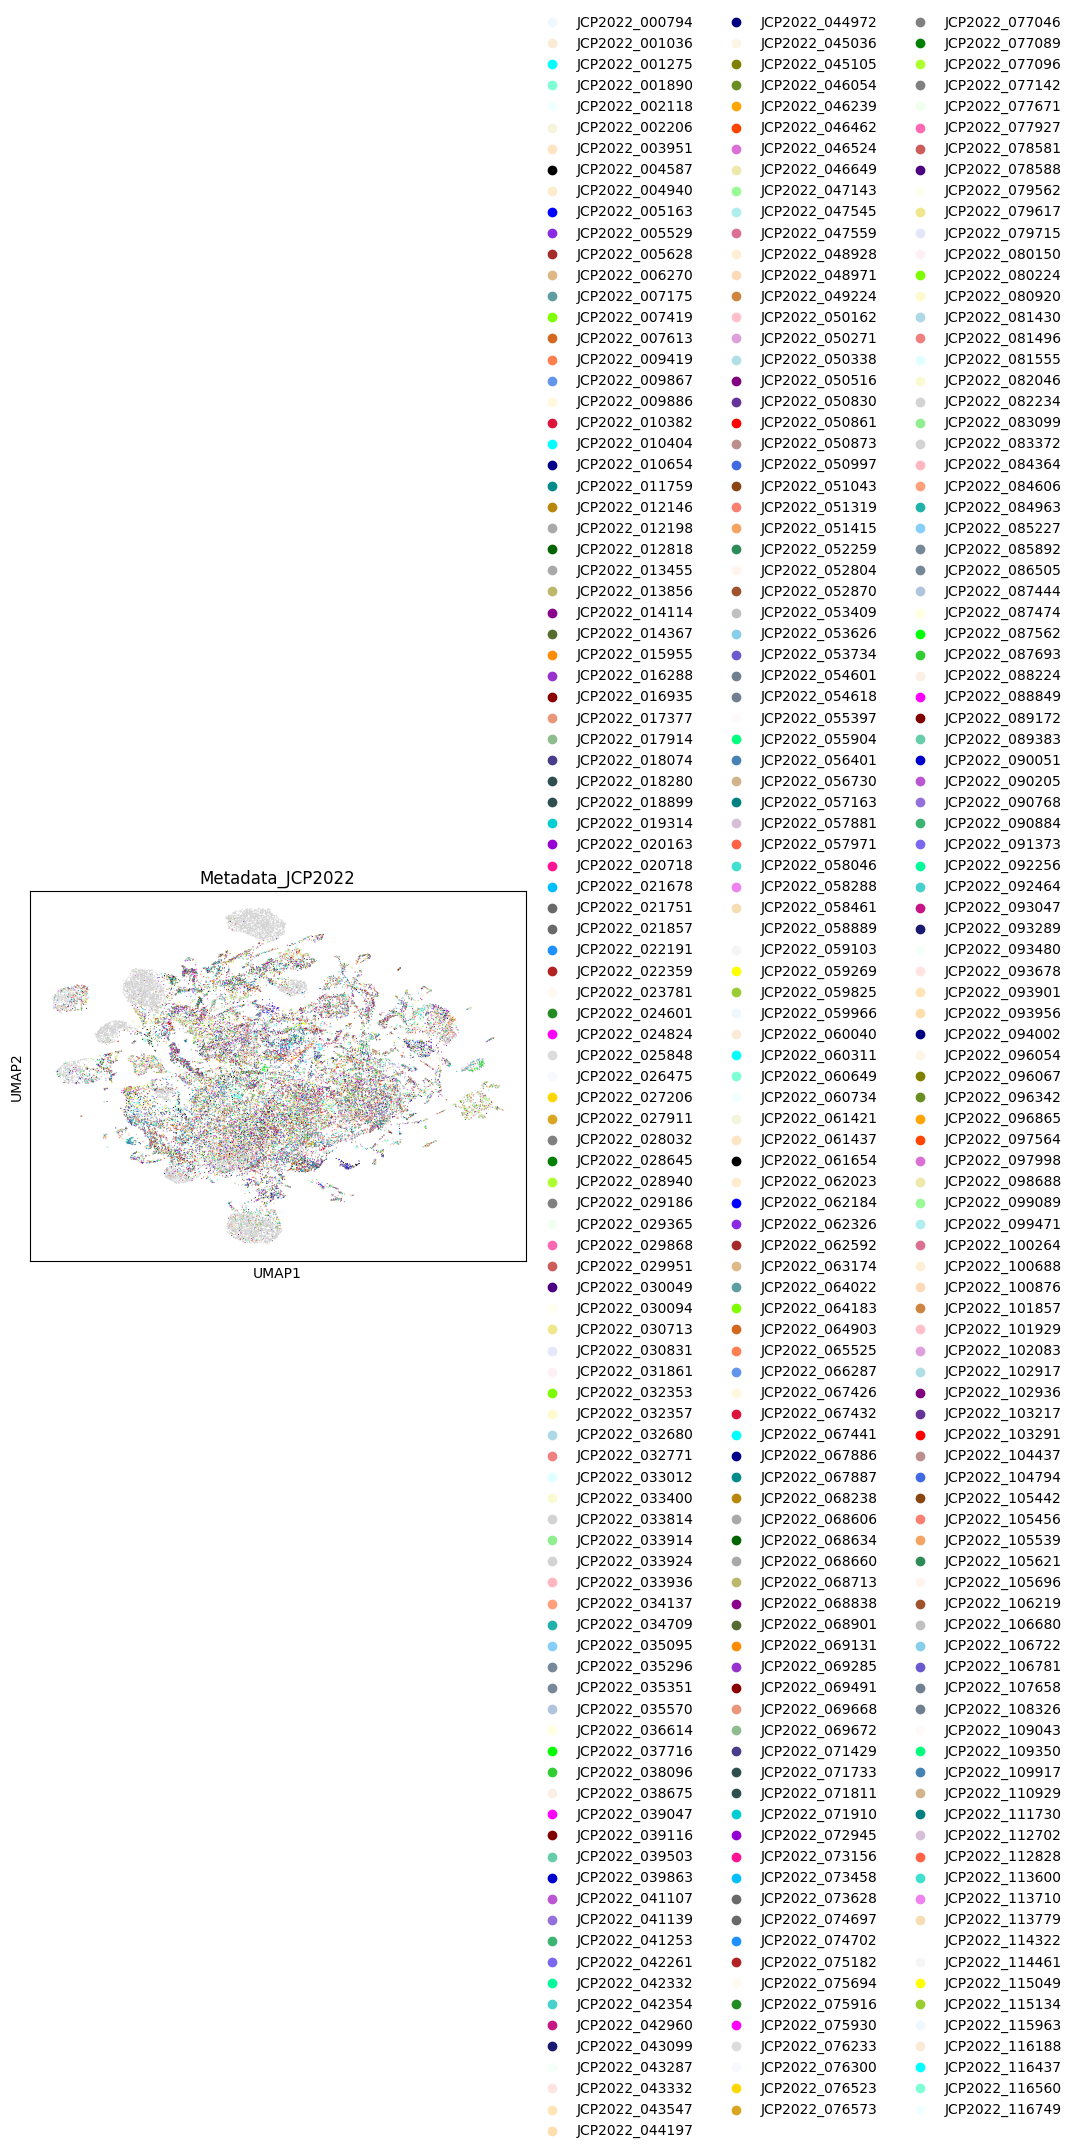

In [8]:
sc.pp.neighbors(scvi_adata, use_rep="X_scvi")
sc.tl.umap(scvi_adata)
sc.pl.umap(scvi_adata, color="Metadata_Source")
sc.pl.umap(scvi_adata, color="Metadata_Plate",palette=list(matplotlib.colors.CSS4_COLORS.values()))
sc.pl.umap(scvi_adata, color="Metadata_JCP2022",palette=list(matplotlib.colors.CSS4_COLORS.values()))

In [13]:
adata_scvi_overall = scvi_integration(reset_corrected_anndata(adata_scvi_per_source, obsm_key = "X_scvi"), batch="Metadata_Source")

/vol/data/ouologuems/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/vol/data/ouologuems/miniconda3/envs/gaushvi/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 159/159: 100%|██████████| 159/159 [10:26<00:00,  3.83s/it, v_num=1, train_loss_step=-24.8, train_loss_epoch=-27]  

`Trainer.fit` stopped: `max_epochs=159` reached.


Epoch 159/159: 100%|██████████| 159/159 [10:26<00:00,  3.94s/it, v_num=1, train_loss_step=-24.8, train_loss_epoch=-27]


In [14]:
adata_scvi_overall

AnnData object with n_obs × n_vars = 50376 × 10
    obs: 'Metadata_JCP2022', 'Metadata_InChIKey', 'Metadata_InChI', 'Metadata_Source', 'Metadata_Plate', 'Metadata_Well', 'Metadata_PlateType', 'SMILES_original', 'SMILES_standardized', 'InChI_standardized', 'InChIKey_standardized', 'broad_sample', 'InChIKey', 'pert_iname', 'pubchem_cid', 'target', 'pert_type', 'control_type', 'moa', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_scvi'
    layers: 'counts'

/vol/data/ouologuems/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/vol/data/ouologuems/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


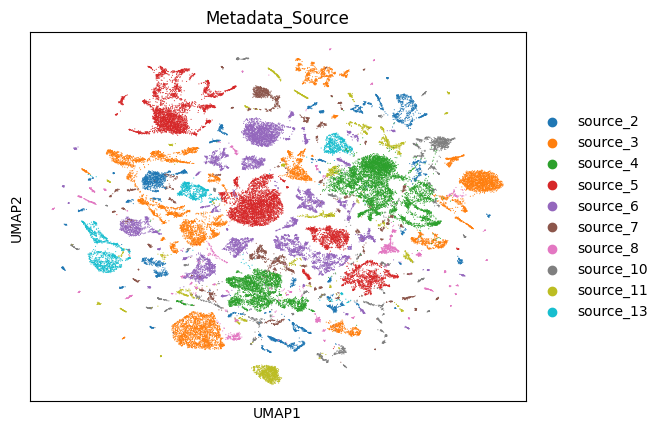

/vol/data/ouologuems/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/vol/data/ouologuems/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


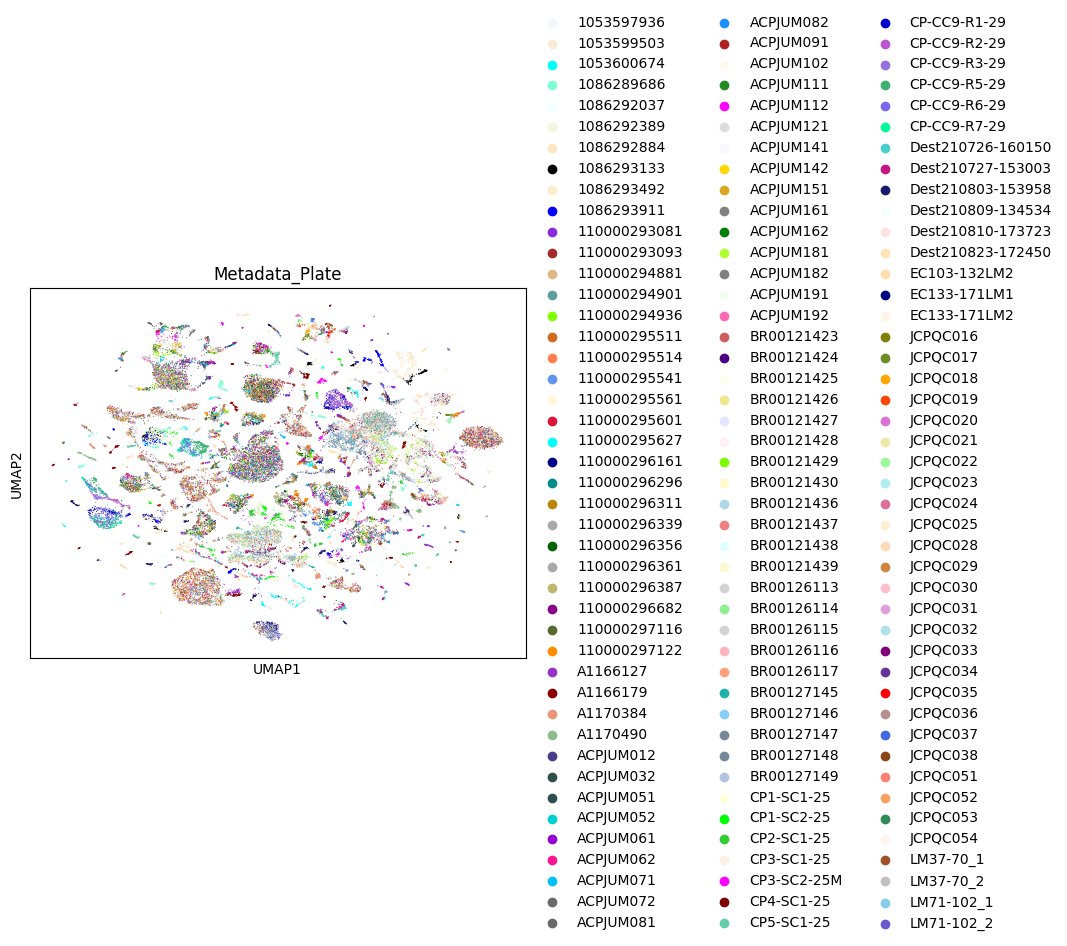

/vol/data/ouologuems/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/vol/data/ouologuems/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


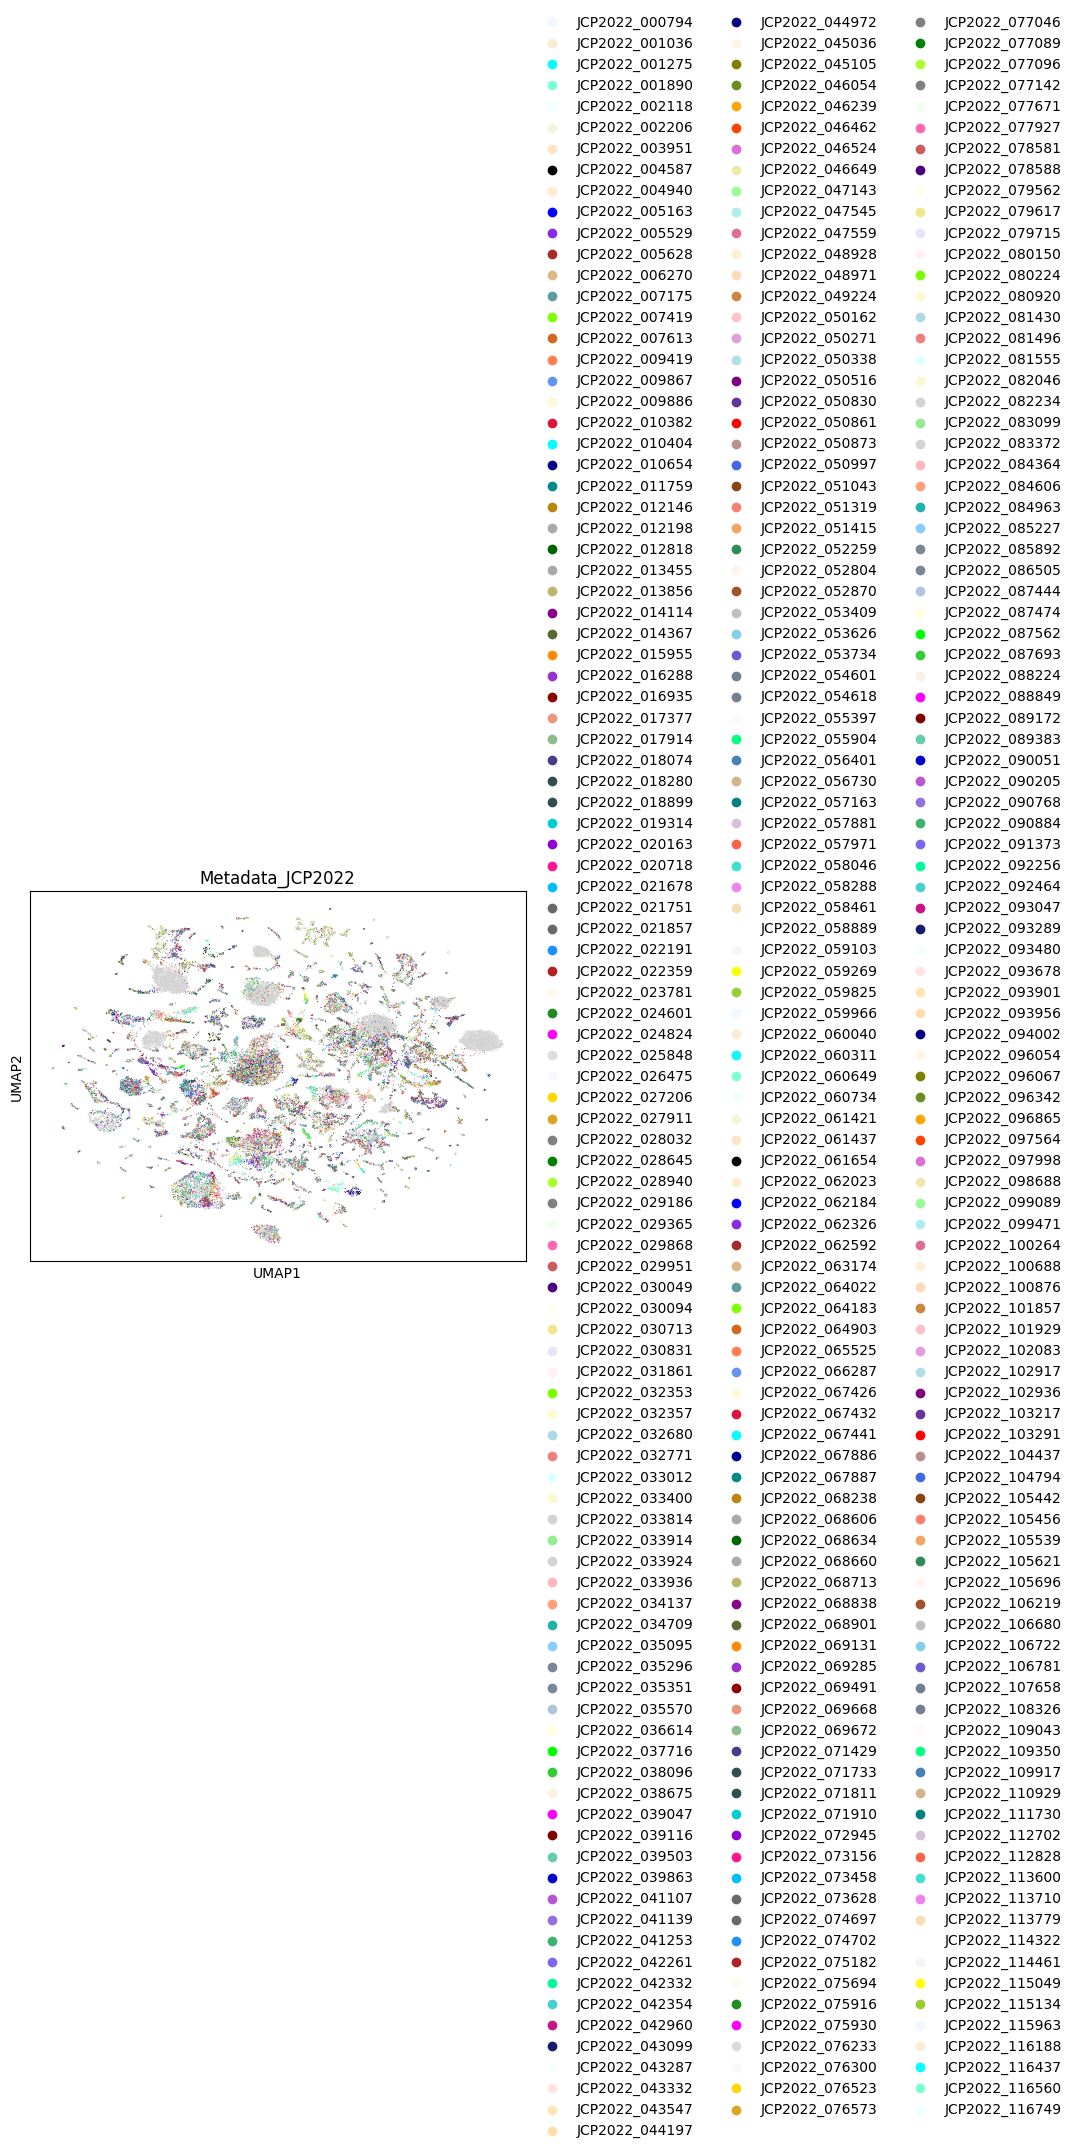

In [15]:
sc.pp.neighbors(adata_scvi_overall, use_rep="X_scvi")
sc.tl.umap(adata_scvi_overall)
sc.pl.umap(adata_scvi_overall, color="Metadata_Source")
sc.pl.umap(adata_scvi_overall, color="Metadata_Plate",palette=list(matplotlib.colors.CSS4_COLORS.values()))
sc.pl.umap(adata_scvi_overall, color="Metadata_JCP2022",palette=list(matplotlib.colors.CSS4_COLORS.values()))